# This explores applying the Hilbert transform to detect the chirp at seizure onset using instantaneous frequency

The chip is from about 116 to 123 seconds

In [3]:
import numpy as np
import pandas as pd
import scipy.io
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
# Reimport functions
import imp
imp.reload(ief)

<module 'ieeg_funcs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/ieeg_funcs.py'>

In [186]:
# Define frequency bands
freq_bands=[(0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
n_band=len(freq_bands)
print('# of freq bands %d' % n_band)

# of freq bands 6


In [187]:
# Load an example data set
#in_fname='/home/dgroppe/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat'
in_fname='/Users/davidgroppe/ONGOING/TWH_EEG_ORIG/NA/NA_d1_sz2.mat'
mat_dat=sio.loadmat(in_fname)
Sf=mat_dat['Sf']
#mat_dat.keys()

# Detrend data. Some patients have a crazy trend in the first channel
vltg_dat=signal.detrend(mat_dat['matrix_bi'],0)
# dat=signal.detrend(vltg_dat,0)
# plt.figure(1)
# plt.clf()
# plt.plot(mat_dat['matrix_bi'][:,0],'b-')
# plt.plot(dat[:,0],'r--')

if Sf==500:
    # Downsample to 250 Hz
    print('Downsampling data to 250 Hz')
    vltg_dat=signal.decimate(vltg_dat,2,axis=0,zero_phase=True)
    Sf=250
elif Sf==250:
    pass
    #vltg_dat=mat_dat['matrix_bi']
else:
    raise ValueError('Sf needs to be 500 or 250')
    
# Get SOZ chan
# soz_id=0 # TODO ?? get actual chan
# n_tpt, n_chan=mat_dat['matrix_bi'].shape
n_tpt, n_chan=vltg_dat.shape
data_time_sec=np.arange(0,n_tpt)/Sf


bp_data=np.zeros((n_band,n_chan,n_tpt))
filt_order=4
# Bandpass filter the data
for band_ct, band in enumerate(freq_bands):
    print('Working on {} Hz'.format(band))
    bp_data[band_ct,:,:]=ief.causal_butter(dat.T,Sf,band,filt_order)
    
# plt.figure(2)
# plt.clf()
# plt.plot(dat[:,0],'r-')
# plt.plot(bp_data[0,0,:],'g--')
# plt.plot(bp_data[3,0,:],'m--')

Downsampling data to 250 Hz
Working on (0, 4) Hz
Working on (4, 8) Hz
Working on (8, 13) Hz
Working on (13, 30) Hz
Working on (30, 50) Hz
Working on (70, 100) Hz


In [152]:
wind_len=Sf
wind_step=int(np.round(Sf/10))
filt_order=4
hilb_mag, hilb_inst_freq, hilb_sec=ief.bp_hilb_mag(vltg_dat[:,soz_id:soz_id+1].T, 
                                                               Sf, wind_len, wind_step,
                                                               data_time_sec, freq_bands, 
                                                               filt_order)
dg.trimmed_normalize(hilb_mag,0.4);

chans 1
tpts 46750
Working on (0, 4) Hz
Working on (4, 8) Hz
Working on (8, 13) Hz
Working on (13, 30) Hz
Working on (30, 50) Hz
Working on (70, 100) Hz
6 dimensions
1860 observations


In [158]:
# Just two freq bands (both almost full band)
freq_bands2=[[0, 120], (1, 125)]
band_labels=['0-120 Hz','1-125 Hz']
wind_len=Sf
wind_step=int(np.round(Sf/10))
filt_order=4
hilb_mag, hilb_inst_freq, hilb_sec=ief.bp_hilb_mag(vltg_dat[:,soz_id:soz_id+1].T, 
                                                               Sf, wind_len, wind_step,
                                                               data_time_sec, freq_bands2, 
                                                               filt_order)
dg.trimmed_normalize(hilb_mag,0.4);

chans 1
tpts 46750
Working on [0, 120] Hz
Working on (1, 125) Hz
2 dimensions
1860 observations


Done.


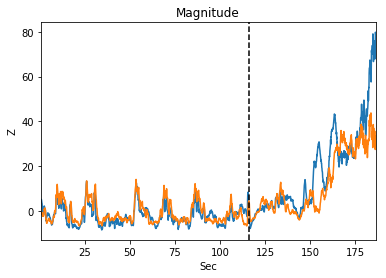

In [159]:
# Magnitude
plt.figure(30)
plt.clf()
plt.plot(hilb_sec,hilb_mag.T)
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Z')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Magnitude')

print('Done.')

Done!


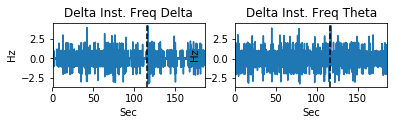

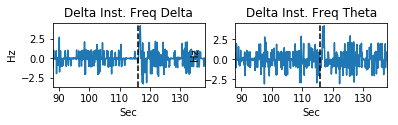

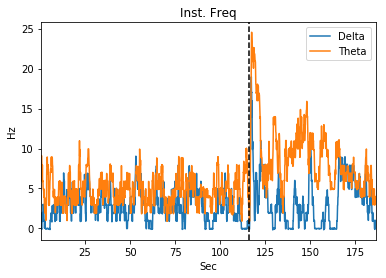

In [188]:
# Instantaneous freq sandbox
n_band=hilb_inst_freq.shape[0]
plt.figure(31)
plt.clf()
for a in range(n_band):
    plt.plot(hilb_sec,hilb_inst_freq[a,:],label=band_labels[a])
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Inst. Freq')
plt.legend()

# Plot change in instantaneous freq
plt.figure(32)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[:-1],np.diff(hilb_inst_freq[a,:]))
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[0], hilb_sec[-1]])
    plt.title('Delta Inst. Freq '+band_labels[a])

    
# Plot change in instantaneous freq (zoom in on onset)
onset_id=dg.find_nearest(hilb_sec,113)
plt.figure(33)
plt.clf()
tempdif=np.diff(hilb_inst_freq);
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[onset_id-Sf:onset_id+Sf],
             tempdif[a,onset_id-Sf:onset_id+Sf])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[onset_id-Sf], hilb_sec[onset_id+Sf]])
    plt.title('Delta Inst. Freq '+band_labels[a])    
    
print('Done!')

['ftr_list', 'time_wind_sec', 'ftrs', 'peri_ictal']
Saving figure to inst_freq_xmple.png
Done.


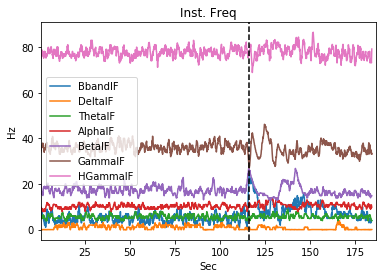

In [197]:
temp_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/IFREQ_LAG0/NA/NA_d1_sz2_ifreq_lag0.npz'
temp_dict=np.load(temp_fname)
print(temp_dict.keys())

n_band=temp_dict['ftrs'].shape[0]
plt.figure(41)
plt.clf()
for a in range(n_band):
    plt.plot(temp_dict['time_wind_sec'],temp_dict['ftrs'][a,:],label=temp_dict['ftr_list'][a])
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Inst. Freq')
plt.legend(loc='center left')

# out_fname='inst_freq_xmple.png'
# print('Saving figure to %s' % out_fname)
# plt.savefig(out_fname)

print('Done.')

In [192]:
print(hilb_inst_freq.shape)
print(temp_dict['ftrs'].shape)
print(np.max(np.abs(hilb_inst_freq-temp_dict['ftrs'][1:,:])))
print(np.max(np.abs(hilb_inst_freq[1:,:]-temp_dict['ftrs'][2:,:])))

plt.figure(50)
plt.clf()
for a in range(6):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_inst_freq[a,:],'b-')
    plt.plot(temp_dict['ftrs'][a+1,:],'r--')
    plt.title(band_labels[a])
    
plt.figure(51)
plt.clf()
plt.plot(hilb_inst_freq[0,:],'b-')
plt.plot(temp_dict['ftrs'][1,:],'r--')

plt.figure(52)
plt.clf()
plt.plot(hilb_inst_freq[0,:],'b-')

print('Done')

(2, 1860)
(7, 1860)


ValueError: operands could not be broadcast together with shapes (2,1860) (6,1860) 

Done!


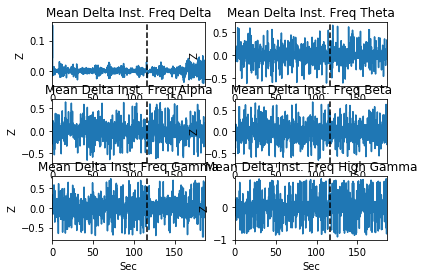

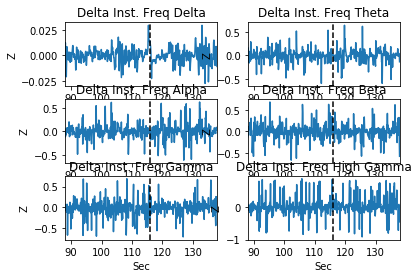

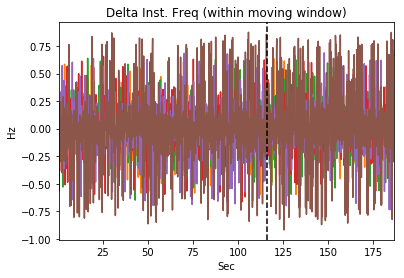

In [92]:
# Delt Instantaneous freq (within the moving window) sandbox
plt.figure(31)
plt.clf()
plt.plot(hilb_sec,hilb_delt_freq.T)
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Delta Inst. Freq (within moving window)')

# Plot mean change in instantaneous freq
plt.figure(32)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec,hilb_delt_freq[a,:])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    #plt.ylabel('Hz')
    plt.ylabel('Z')
    plt.xlim([hilb_sec[0], hilb_sec[-1]])
    plt.title('Mean Delta Inst. Freq '+band_labels[a])

    
# Plot change in instantaneous freq (zoom in on onset)
onset_id=dg.find_nearest(hilb_sec,113)
plt.figure(33)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[onset_id-Sf:onset_id+Sf],
             hilb_delt_freq[a,onset_id-Sf:onset_id+Sf])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    #plt.ylabel('Hz')
    plt.ylabel('Z')
    plt.xlim([hilb_sec[onset_id-Sf], hilb_sec[onset_id+Sf]])
    plt.title('Delta Inst. Freq '+band_labels[a])    
    
print('Done!')

Done!


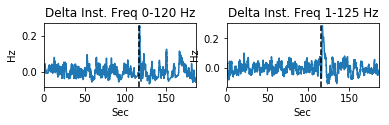

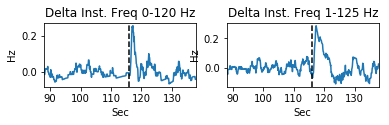

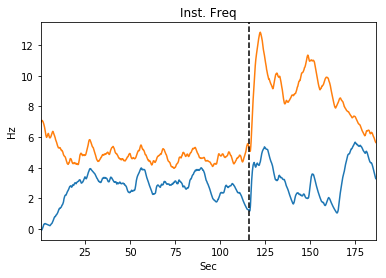

In [161]:
# SMOOOTHED Instantaneous freq sandbox
smooth_inst_freq=np.copy(hilb_inst_freq)
n_wind=hilb_inst_freq.shape[1]
pptn=1/(2**6) #smaller values=more smoothing
for a in range(0,n_wind-1):
    smooth_inst_freq[:,a+1]=(1-pptn)*smooth_inst_freq[:,a]+pptn*smooth_inst_freq[:,a+1]

plt.figure(31)
plt.clf()
plt.plot(hilb_sec,smooth_inst_freq.T)
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Inst. Freq')

# Plot change in instantaneous freq
plt.figure(32)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[:-1],np.diff(smooth_inst_freq[a,:]))
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[0], hilb_sec[-1]])
    plt.title('Delta Inst. Freq '+band_labels[a])

    
# Plot change in instantaneous freq (zoom in on onset)
onset_id=dg.find_nearest(hilb_sec,113)
plt.figure(33)
plt.clf()
tempdif=np.diff(smooth_inst_freq);
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[onset_id-Sf:onset_id+Sf],
             tempdif[a,onset_id-Sf:onset_id+Sf])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[onset_id-Sf], hilb_sec[onset_id+Sf]])
    plt.title('Delta Inst. Freq '+band_labels[a])    
    
print('Done!')

In [7]:
# Apply NON-causal hilbert transform
soz_id=12
hilby_data=signal.hilbert(bp_data[:,soz_id,:])
print('done!')

done!


In [178]:
difreq.keys()

['time_wind_sec', 'ftrs', 'ftr_list', 'peri_ictal']

['peri_ictal', 'ftr_list', 'ftrs', 'time_wind_sec']
Saving figure to inst_diffreq_xmple.png


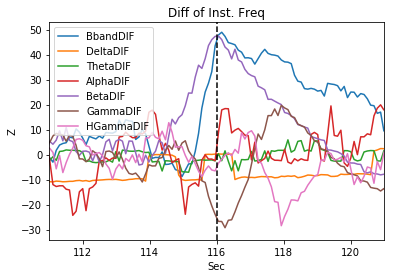

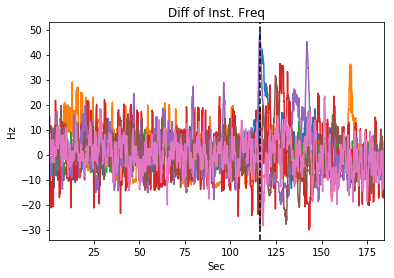

In [200]:
difreq_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/DIFREQ_LAG8/NA/NA_d1_sz2_difreq_lag8.npz'
difreq=np.load(difreq_fname)
print(difreq.keys())

plt.figure(31)
plt.clf()
plt.plot(difreq['time_wind_sec'],difreq['ftrs'].T)
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([difreq['time_wind_sec'][0], difreq['time_wind_sec'][-1]])
plt.title('Diff of Inst. Freq');

plt.figure(32)
plt.clf()
for a in range(difreq['ftrs'].shape[0]):
    plt.plot(difreq['time_wind_sec'],difreq['ftrs'][a,:],label=difreq['ftr_list'][a])
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
# plt.ylabel('Hz')
plt.ylabel('Z')
plt.xlim([111, 121])
plt.legend()
plt.title('Diff of Inst. Freq');

out_fname='inst_diffreq_xmple.png'
print('Saving figure to %s' % out_fname)
plt.savefig(out_fname)

In [8]:
hilby_mag=np.abs(hilby_data)
hilby_phz=np.unwrap(np.angle(hilby_data))
instant_freq = (np.diff(hilby_phz)/(2.0*np.pi) * Sf)
hilby_mag.shape

(6, 46750)

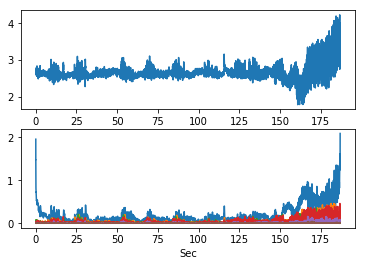

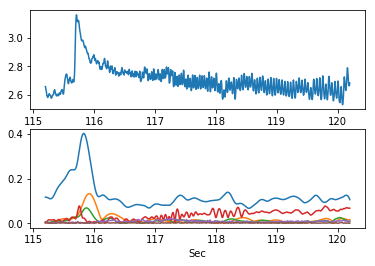

In [9]:
# Plot raw data and magnitude
plt.figure(1)
plt.clf()
plt.subplot(2,1,1)
plt.plot(data_time_sec,vltg_dat[:,soz_id])

plt.subplot(2,1,2)
plt.plot(data_time_sec,hilby_mag.T);
plt.xlabel('Sec')

start_tpt=28800
stop_tpt=start_tpt+Sf*5
plt.figure(2)
plt.clf()
plt.subplot(2,1,1)
plt.plot(data_time_sec[start_tpt:stop_tpt],vltg_dat[start_tpt:stop_tpt,soz_id])

plt.subplot(2,1,2)
plt.plot(data_time_sec[start_tpt:stop_tpt],hilby_mag[:,start_tpt:stop_tpt].T);
plt.xlabel('Sec')

6 dimensions
1250 observations
31 dimensions
1250 observations
done!


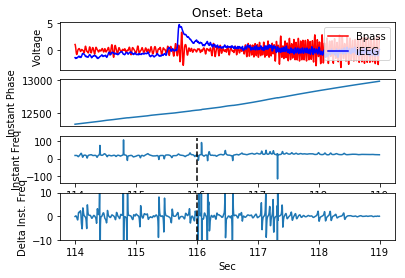

In [10]:
# freq_bands=[(0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
# band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
# n_band=len(freq_bands)

freq_id=3 # 3=beta

# Plot raw data and phase
start_tpt=28500
stop_tpt=start_tpt+Sf*5
plt.figure(2)
plt.clf()
plt.subplot(4,1,1)
#plt.plot(vltg_dat[start_tpt:stop_tpt,soz_id])
#plt.plot(bp_data[freq_id,soz_id,start_tpt:stop_tpt],'r-')
show_dat=np.copy(bp_data[:,soz_id,start_tpt:stop_tpt])
show_raw_dat=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
dg.normalize(show_dat)
#dg.trimmed_normalize(show_raw_dat,0.4)
dg.normalize(show_raw_dat)
plt.plot(show_dat[freq_id,:],'r-',label='Bpass')
#plt.plot(show_raw_dat[:,soz_id],'b-')
plt.plot(show_raw_dat[soz_id,:],'b-',label='iEEG')
plt.xticks([])
plt.legend()
plt.ylabel('Voltage')
plt.title('Onset: '+band_labels[freq_id])

plt.subplot(4,1,2)
plt.plot(hilby_phz[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(4,1,3)
plt.plot(data_time_sec[start_tpt:stop_tpt],instant_freq[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Freq')
ylim=plt.ylim()
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')
#plt.plot([123, 123],ylim,'k--')

plt.subplot(4,1,4)
plt.plot(data_time_sec[start_tpt:stop_tpt-1],np.diff(instant_freq[freq_id,start_tpt:stop_tpt]));
plt.ylabel('Delta Inst. Freq')
plt.ylim([-10, 10])
ylim=plt.ylim()
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')
# plt.plot([123, 123],ylim,'k--')
plt.xlabel('Sec')

print('done!')

done!


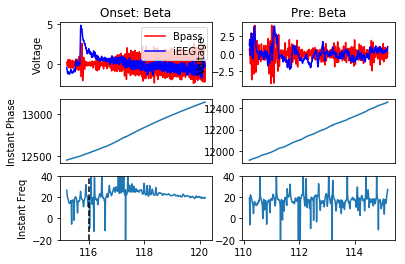

In [11]:
# HILBERT ON ENTIRE DATA 

# Plot raw data and phase
# freq_bands=[(0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
# band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
# n_band=len(freq_bands)

freq_id=3 # 3=beta
a=0
ylim=[-20, 40]

# onset
start_tpt=28800
stop_tpt=start_tpt+Sf*5
dat_clip=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,start_tpt:stop_tpt]))
                
plt.figure(2)
plt.clf()
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],bp_clipZ,'r-',label='Bpass')
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.legend()
plt.ylabel('Voltage')
plt.title('Onset: '+band_labels[freq_id])

plt.subplot(3,2,3+a)
plt.plot(np.arange(start_tpt,stop_tpt),hilby_phz[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],instant_freq[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Freq')
plt.ylim(ylim)
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')

## PRE-onset
pre_tpt=start_tpt-Sf*5
dat_clip=np.copy(vltg_dat[pre_tpt:start_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,pre_tpt:start_tpt]))
a=1
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(np.arange(pre_tpt,start_tpt),bp_clipZ,'r-',label='Bpass')
plt.plot(np.arange(pre_tpt,start_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
#plt.legend()
plt.ylabel('Voltage')
plt.title('Pre: '+band_labels[freq_id])

plt.subplot(3,2,3+a)
plt.plot(np.arange(pre_tpt,start_tpt),hilby_phz[freq_id,pre_tpt:start_tpt].T);
# plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(pre_tpt,start_tpt)],instant_freq[freq_id,pre_tpt:start_tpt].T);
plt.ylim(ylim)

print('done!')

Done


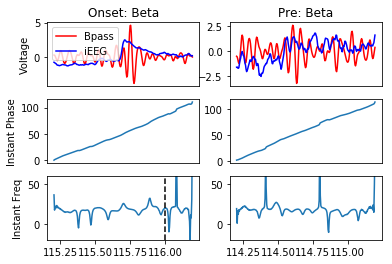

In [14]:
# HILBERT ON JUST THE n_sec SECOND CLIP, bandpassed
freq_id=3 # 3=beta
a=0
ylim=[-20, 60]

# onset
#n_sec=5
n_sec=1
start_tpt=28800
stop_tpt=start_tpt+Sf*n_sec
dat_clip=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,start_tpt:stop_tpt]))
                
plt.figure(2)
plt.clf()
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(np.arange(start_tpt,stop_tpt),bp_clipZ,'r-',label='Bpass')
plt.plot(np.arange(start_tpt,stop_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.legend()
plt.ylabel('Voltage')
plt.title('Onset: '+band_labels[freq_id])

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(bp_data[freq_id,soz_id,start_tpt:stop_tpt])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(start_tpt,stop_tpt),np.abs(hilby_clip))
plt.plot(np.arange(start_tpt,stop_tpt),hilby_clip_phz);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(start_tpt+1,stop_tpt)],clip_instant_freq);
plt.ylabel('Instant Freq')
plt.ylim(ylim)
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')

## PRE-onset
pre_tpt=start_tpt-Sf*n_sec
dat_clip=np.copy(vltg_dat[pre_tpt:start_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,pre_tpt:start_tpt]))
a=1

plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(np.arange(pre_tpt,start_tpt),bp_clipZ,'r-',label='Bpass')
plt.plot(np.arange(pre_tpt,start_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.title('Pre: '+band_labels[freq_id])

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(bp_data[freq_id,soz_id,pre_tpt:start_tpt])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(pre_tpt,start_tpt),np.abs(hilby_clip))
plt.plot(np.arange(pre_tpt,start_tpt),hilby_clip_phz);
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(pre_tpt+1,start_tpt)],clip_instant_freq);
plt.ylim(ylim)

print('Done')

Done


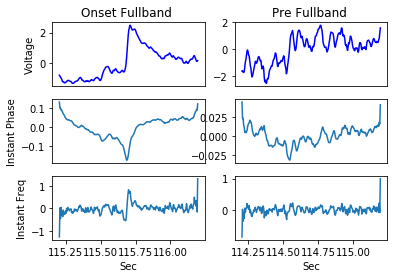

In [16]:
# HILBERT ON JUST THE n_sec SECOND CLIP, NO bandpass
a=0
ylim=[-20, 40]

# onset
#n_sec=5 
n_sec=1 
start_tpt=28800
stop_tpt=start_tpt+Sf*n_sec
dat_clip=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,start_tpt:stop_tpt]))
                
plt.figure(2)
plt.clf()
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
plt.plot(np.arange(start_tpt,stop_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.ylabel('Voltage')
plt.title('Onset Fullband ')

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(dat_clip[soz_id,:])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(start_tpt,stop_tpt),np.abs(hilby_clip))
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],hilby_clip_phz);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(start_tpt+1,stop_tpt)],clip_instant_freq);
plt.ylabel('Instant Freq')
#plt.ylim(ylim)
plt.xlabel('Sec')

## PRE-onset
pre_tpt=start_tpt-Sf*n_sec
dat_clip=np.copy(vltg_dat[pre_tpt:start_tpt,:]).T
a=1

plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
plt.plot(np.arange(pre_tpt,start_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.title('Pre Fullband ')

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(dat_clip[soz_id,:])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(pre_tpt,start_tpt),np.abs(hilby_clip))
plt.plot(np.arange(pre_tpt,start_tpt),hilby_clip_phz);
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(pre_tpt+1,start_tpt)],clip_instant_freq);
#plt.ylim(ylim)
plt.xlabel('Sec')

print('Done')

In [113]:
# Find out exactly where the chirp is using a spectrogram
wind_len=Sf
wind_step=int(np.round(wind_len/10))
n_tapers=4
sgram, f, sgram_sec=ief.mt_sgram(vltg_dat[:,soz_id], Sf, wind_len, wind_step, n_tapers,
                                 data_time_sec)
dg.trimmed_normalize(sgram,0.4);

126 dimensions
1860 observations


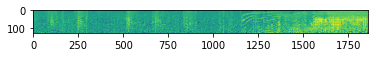

In [114]:
plt.figure(4)
plt.clf()
plt.imshow(sgram)

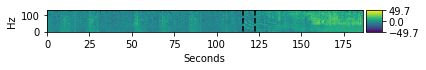

In [122]:
ief.sgram_plot(sgram,sgram_sec,title=None,fname='temp_chip.png',
           fig_id=4,onset_lower_bnd_sec=116,onset_upper_bnd_sec=123)
# The chip is from about 116 to 123 seconds

In [5]:
# Import Channel Info
in_fname='/Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv'
chan_df=pd.read_csv(in_fname,names=['Channel'])
for chan_ct, chan in enumerate(chan_df['Channel']):
    print('%d: %s' % (chan_ct,chan))
#pd.read_csv?

0: LHD1-LHD2
1: LHD2-LHD3
2: LHD3-LHD4
3: LAT1-LAT2
4: LAT2-LAT3
5: LAT3-LAT4
6: LMT1-LMT2
7: LMT2-LMT3
8: LMT3-LMT4
9: LPT1-LPT2
10: LPT2-LPT3
11: LPT3-LPT4
12: RHD1-RHD2
13: RHD2-RHD3
14: RHD3-RHD4
15: RAT1-RAT2
16: RAT2-RAT3
17: RAT3-RAT4
18: RMT1-RMT2
19: RMT2-RMT3
20: RMT3-RMT4
21: RSPT1-RSPT2
22: RSPT2-RSPT3
23: RSPT3-RSPT4
24: RSPT4-RSPT5
25: RSPT5-RSPT6
26: RIPT1-RIPT2
27: RIPT2-RIPT3
28: RIPT3-RIPT4
29: RIPT4-RIPT5
30: RIPT5-RIPT6


In [6]:
# Extract power magnitude from hilbert transform
soz_id=12
bp_mag=np.abs(hilby_data[:,soz_id,:])

In [7]:
bp_data.shape

(6, 31, 46750)

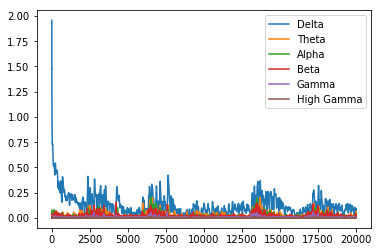

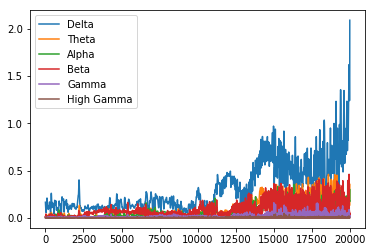

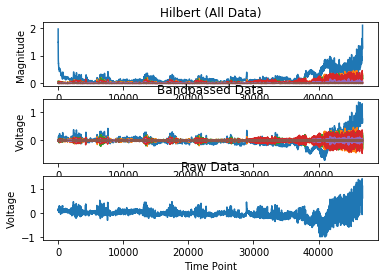

In [8]:
plt.figure(1)
plt.clf()
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,0:20000].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(2)
plt.clf()
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,-20000:].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(3)
plt.clf()
plt.subplot(3,1,1)
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Hilbert (All Data)')
plt.ylabel('Magnitude')

plt.subplot(3,1,2)
for band_ct in range(n_band):
    plt.plot(bp_data[band_ct,soz_id,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Bandpassed Data')
plt.ylabel('Voltage')

plt.subplot(3,1,3)
plt.plot(dat[:,soz_id])
plt.title('Raw Data')
plt.xlabel('Time Point')
plt.ylabel('Voltage')

plt.savefig('hilbert_mag_all_data.png')

In [ ]:
# Square, Log transform and z-score features for comparison with DFT features
bp_mag_z=np.log(bp_mag.copy()**2)
# print(bp_mag[0,0])
# print(bp_mag_z[0,0])
dg.trimmed_normalize(bp_mag_z,0.4);

In [ ]:
# Load DFT based features and compare with Hilbert based Features
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/NA/NA_d1_sz2_bppwr.npz'
dft=np.load(in_fname)
dft.keys()

n_dft_tpt=len(dft['time_wind_sec'])
resamp_bp_mag_z=np.zeros((n_band,n_dft_tpt))
for a in range(n_dft_tpt):
    match_id=dg.find_nearest(hilby_time_sec,dft['time_wind_sec'][a])
    resamp_bp_mag_z[:,a]=np.mean(bp_mag_z[:,match_id-125:match_id+125],axis=1)

In [ ]:
print(dft['time_wind_sec'].shape)
print(hilby_time_sec.shape)
bro=np.mean(bp_mag_z[:,match_id-125:match_id+125],axis=1)
bro.shape

In [ ]:
plt.figure(3)
plt.clf()
for band_ct in range(n_band):
    plt.plot(resamp_bp_mag_z[band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(4)
plt.clf()
for band_ct in range(n_band):
    plt.plot(dft['ftrs'][band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()